# THE MARCENKO–PASTUR (MP) PDF


Assymptotic distribution of eigenvalues of a specific random matrix. https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution

 The code above shows how well MP pdf explains eigenvalues of random matrix x

In [1]:
400 * 250

100000

In [2]:
12500 / 250

50.0

In [3]:
import matplotlib.pyplot as plt
import numpy as np,pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

C:\Users\r0913246\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N (>1)
    # pts - amount of points
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

In [5]:

def getPCA(matrix):
# Get eVal,eVec from a !!!Hermitian matrix (cov matrix is a hermitian matrix)
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec


def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

In [6]:
15000 / 250

60.0

In [7]:
np.random.seed(32)

N = 1000#1000  # num of vars #N = 250, T = 3000, nFacts = 50 -> Not bad
T = 15000#10000 # num of observations
tmp_nFact = 50
x = np.random.normal(0, 1, size = (T, N))
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.09) #empirical pdf


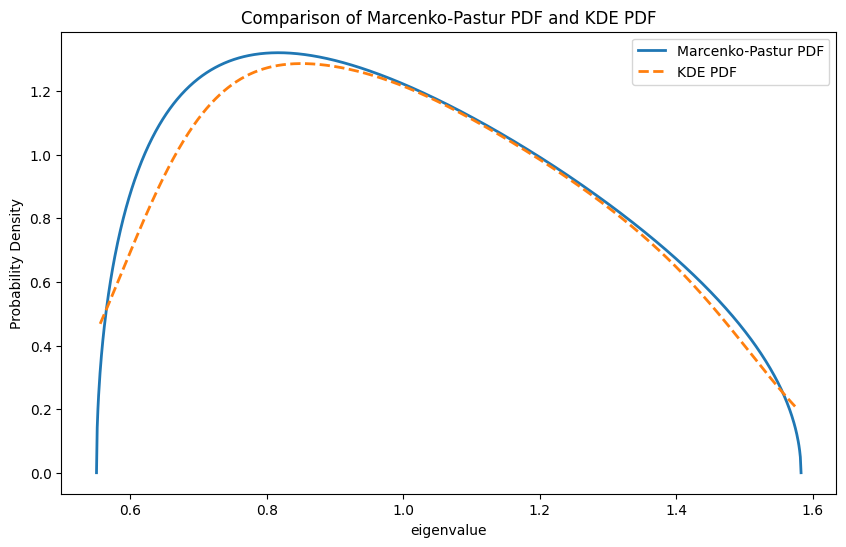

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur PDF', linewidth=2)
plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# MP for not perfectly random function

The code above shows how MP works with not perfectly random function.

_____
Look at RANDOM MATRIX THEORY AND FINANCIAL CORRELATIONS LAURENT LALOUX, PIERRE CIZEAU and MARC POTTERS to understand the approach

In [9]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

(array([1.16306358, 1.572593  , 1.54802124, 1.35144711, 1.10572946,
        0.7862965 , 0.25390825, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00819059, 0.02457177,
        0.01638118, 0.00819059, 0.00819059, 0.03276235, 0.01638118,
        0.01638118, 0.00819059, 0.02457177, 0.02457177, 0.01638118,
        0.01638118, 0.02457177, 0.00819059, 0.02457177, 0.01638118,
        0.01638118, 0.01638118, 0.00819059, 0.01638118, 0.00819059,
        0.00819059, 0.01638118, 0.01638118, 0.        , 0.00819059]),
 array([0.44884504, 0.57093639, 0.69302774, 0.81511908, 0.93721043,
        1.05930178, 1.18139313, 1.30348448, 1.42557582, 1.54766717,
        1.66975852, 1.79184987, 1.91394122, 2.03603257, 2.15812391,
        2.28021526, 2.40230661, 2.52439796, 2.64648931, 2.76858065,
        2.890672  , 3.01276335, 3.1348547 , 3.

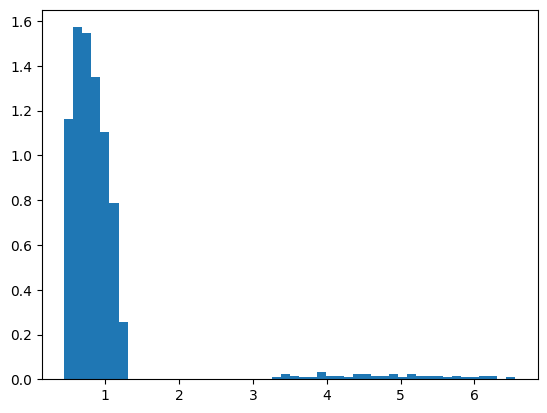

In [10]:
np.random.seed(32)

alpha, nCols, nFact, q = .995, N, tmp_nFact, T // N
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
corr0 = cov2corr(cov)
eVal01, eVec01 = getPCA(corr0)
#pdf2 = fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf

    # Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

In [11]:
# find expected max eigenvalue and variance that maximizes the distance
eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)

sse:2368.665330508995
sse:2368.665127326272
sse:236.20322835773374
sse:236.20321732905666
sse:206.82137294314924
sse:206.8213847713829
sse:67.24063201822517
sse:67.24064553963693
sse:3328.538138913612
sse:3328.537866692355
sse:5.07547168472956
sse:5.075472610218819
sse:11.737988835285842
sse:11.737980426130493
sse:4.989742085520417
sse:4.98974214913244
sse:4.989345834958794
sse:4.989345833621158
sse:4.9893456592943375
sse:4.989345659296118
sse:4.989345659294957
sse:4.989345659294937
sse:4.989345659294427
sse:4.989345659295926
sse:4.989345659294351
sse:4.9893456592961325
sse:4.989345659294371
sse:4.989345659296127
sse:4.98934565929442
sse:4.989345659296159
sse:4.9893456592943375
sse:4.989345659296118
sse:4.989345659294325
sse:4.989345659296113
sse:4.989345659294402
sse:4.989345659296088
sse:4.989345659294325
sse:4.989345659296113
sse:4.989345659294365
sse:4.989345659296115
sse:4.989345659294325
sse:4.989345659296113
sse:4.98934565929441
sse:4.989345659296153
sse:4.989345659294325
sse:4.

**The fitted distribution implies that σ² ≈ 0.6768, indicating that only about 32.32% of the variance is signal. This is one way of measuring the signal-to-noise ratio in financial data sets, which is known to be low as a result of arbitrage forces.**


In [12]:
var0

1

In [13]:
# calculate the number of factors (nFacts0) that have eigenvalues greater than a specified threshold (eMax0)nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)




In [14]:
q

15

In [15]:
nFacts0

50

In [16]:
len(eVal01)

1000

In [17]:
pdf0 = mpPDF(var0, q=x.shape[0]/float(x.shape[1]), pts=N)

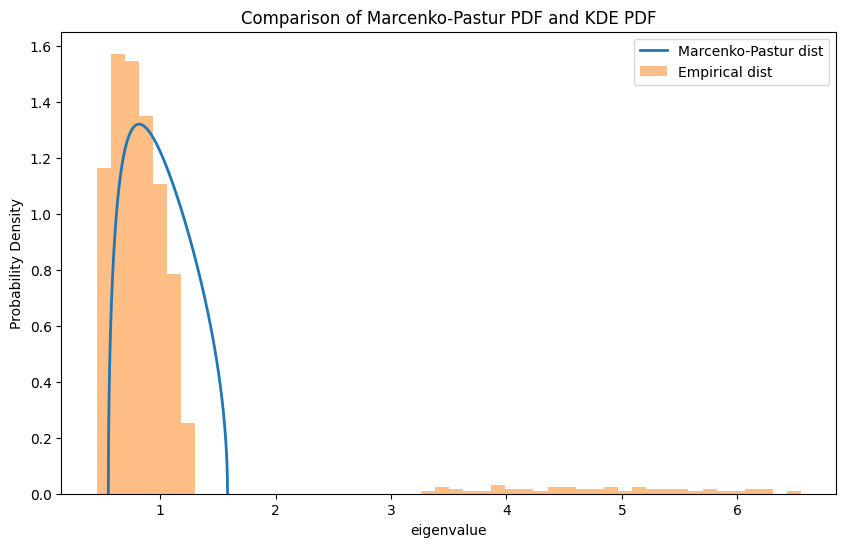

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur dist', linewidth=2)
plt.hist(np.diag(eVal01), bins=50, density=True, alpha=0.5, label='Empirical dist')

#plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [19]:
eVal01

array([[6.55341245, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.29186415, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 6.23682639, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.45608379, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.45126   ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.44884504]])

In [20]:
# replace in random eigenvalues by constants
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1

In [21]:
corr1=denoisedCorr(eVal01,eVec01,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [26]:
max_, var_ = findMaxEval(np.diag(eVal01), q, bWidth=.01)

sse:2368.665330508995
sse:2368.665127326272
sse:236.20322835773374
sse:236.20321732905666
sse:206.82137294314924
sse:206.8213847713829
sse:67.24063201822517
sse:67.24064553963693
sse:3328.538138913612
sse:3328.537866692355
sse:5.07547168472956
sse:5.075472610218819
sse:11.737988835285842
sse:11.737980426130493
sse:4.989742085520417
sse:4.98974214913244
sse:4.989345834958794
sse:4.989345833621158
sse:4.9893456592943375
sse:4.989345659296118
sse:4.989345659294957
sse:4.989345659294937
sse:4.989345659294427
sse:4.989345659295926
sse:4.989345659294351
sse:4.9893456592961325
sse:4.989345659294371
sse:4.989345659296127
sse:4.98934565929442
sse:4.989345659296159
sse:4.9893456592943375
sse:4.989345659296118
sse:4.989345659294325
sse:4.989345659296113
sse:4.989345659294402
sse:4.989345659296088
sse:4.989345659294325
sse:4.989345659296113
sse:4.989345659294365
sse:4.989345659296115
sse:4.989345659294325
sse:4.989345659296113
sse:4.98934565929441
sse:4.989345659296153
sse:4.989345659294325
sse:4.

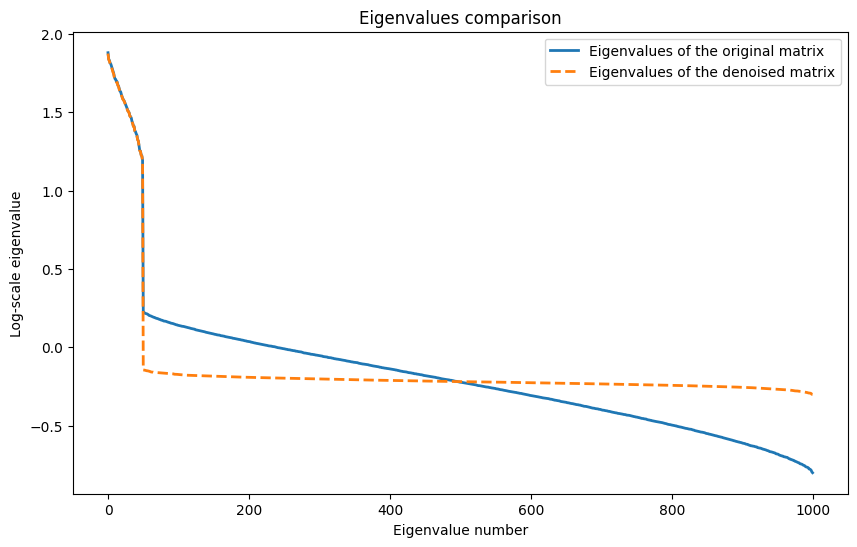

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(N), np.log(np.diag(eVal01)), label='Eigenvalues of the original matrix', linewidth=2)
plt.plot(range(N), np.log(np.diag(eVal1)),  label='Eigenvalues of the denoised matrix', linewidth=2, linestyle='--')
#plt.hist(np.diag(eVal01), bins=50, density=True, alpha=0.5, label='Empirical dist')


#plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Eigenvalues comparison')
plt.xlabel('Eigenvalue number')
plt.ylabel('Log-scale eigenvalue')
plt.legend()
plt.show()

In [24]:
#Generate a block-diagnoal covariance matrix and a vector of means
# Block represent sector
# bSize  number of assets in the sector
# bCorr correlation between assets in the sector
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones( (bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1 #diagonal is 1
    corr = block_diag(*([block]*nBlocks))
    return corr



def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0, cov0

nBlocks, bSize, bCorr=10,50,.5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

In [21]:
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

# Denoising of the empirical covariance matrix
# by constant residual eigenvalue method
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1


# function to obtain empirical from true matrix with and without shrink
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1

In [22]:
formBlockMatrix(3, 2, 0.5)

array([[1. , 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0.5],
       [0. , 0. , 0. , 0. , 0.5, 1. ]])

# Experiment (portfolio with shorting)

In [23]:
# find min var portfolio
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w

## Without shrinkage 

To test shrinkage effec tset shrink = True

In [24]:
nBlocks, bSize, bCorr = 10, 50, .5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

nObs, nTrials, bWidth, shrink, minVarPortf = 20, 5, .01, False, True
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(nTrials), dtype=float) # contains weights of non-denoised portf

w1_d = w1.copy(deep=True) # contains weights of denoised portfolio
np.random.seed(0)
for i in range(nTrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf: mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten() # np.sum(w1_d, axis=1) is vector of 1's. sum(np.sum(w1_d, axis=0)= nTrials
    # so minimum-variance-portfolio is 1./nTrials*(np.sum(w1_d, axis=0)) - but distribution not stationary
    
min_var_port = 1./nTrials*(np.sum(w1_d, axis=0)) 
#code snippet 2.11
w0 = optPort(cov0, None if minVarPortf else mu0) # w0 true percentage asset allocation
w0 = np.repeat(w0.T, w1.shape[0], axis=0) 
rmsd = np.mean((w1-w0).values.flatten()**2)**.5     #RMSE not denoised
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE denoised
print("RMSE not denoised:"+str( rmsd))
print("RMSE denoised:"+str( rmsd_d))

sse:0.11264189734808182
sse:0.11264189540052369
sse:0.08910842676914812
sse:0.08910844555297272
sse:0.10790785547358772
sse:0.10790785411977036
sse:0.10854511298259212
sse:0.1085451121747471
sse:0.10583705312544635
sse:0.10583705249433514
sse:0.11443551790047128
sse:0.1144355154200232
sse:0.10582988409209708
sse:0.10582988243952728
sse:0.10578953221182943
sse:0.10578952964749504
sse:0.10495110002638991
sse:0.10495109667272307
sse:0.1049281615061116
sse:0.10492815892185109
sse:0.10490613418233477
sse:0.10490613250234282
sse:0.1149501492876788
sse:0.114950144684426
sse:0.10490470892560758
sse:0.10490470725480344
sse:0.11512562267923415
sse:0.11512562597599323
sse:0.10490408289618447
sse:0.10490408122824005
sse:0.11176579622662541
sse:0.11176601266483431
sse:0.10490251710645118
sse:0.10490251544415136
sse:0.10634108225559483
sse:0.10634121758973615
sse:0.10488722573120432
sse:0.104887225189216
sse:0.10907973656869167
sse:0.10907973238440083
sse:0.113256982990496
sse:0.11325714217620333
ss

In [25]:
w0.shape

(5, 500)